## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Conclusion](#conclusion)


<a id='intro'></a>
### Introduction

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

Import he necessary libraries and fix the random seed for review

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` The target data is stored in `ab_data.csv`.

a. Read in the dataset

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Number of rows in the dataset.

In [9]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [6]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [11]:
df.query('converted == 1').user_id.count()/df.user_id.nunique()

0.12126269856564711

e. The number of times the `new_page` and `treatment` don't line up.

In [20]:
df.query('group == "control" and landing_page == "new_page"').user_id.count() + df.query('group == "treatment" and landing_page == "old_page"').user_id.count()

3893

f. Number of missing values

In [19]:
df.shape[0] - df.dropna().shape[0]

0

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.

a. Create a new dataset removing the entries mentioned above. Store your new dataframe in **df2**.

In [3]:
df2=df.query('group == "treatment" and landing_page == "new_page"').append(df.query('group == "control" and landing_page == "old_page"')).reset_index(drop=True)

In [4]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` **df2** data cleaning

a. How many unique **user_id**s are in **df2**?

In [86]:
df2.user_id.nunique()

290584

b. Repeated **user_id** in **df2**.

In [91]:
df2.groupby('user_id').size().sort_values(ascending = False).head(1)

# Or df2.user_id.value_counts().head(1)

user_id
773192    2
dtype: int64

c. What is the row information for the repeated **user_id**? 

In [5]:
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
938,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
1404,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [6]:
df2.drop([1404], inplace = True)

`4.` Propability associated with conversion rates in **df2**

a. What is the probability of an individual converting regardless of the page they receive?

In [7]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [8]:
p_control = df2.query('group == "control"').converted.mean()
p_control

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [9]:
p_treatment = df2.query('group == "treatment"').converted.mean()
p_treatment

0.11880806551510564

In [10]:
p_treatment - p_control

-0.0015782389853555567

d. What is the probability that an individual received the new page?

In [11]:
df2.query('group == "treatment"').user_id.count()/df2.shape[0]

0.5000619442226688

**Observation**: The probability for each page is balanced (answer d.), no further data manipulation is required

Regarding the dataset, there is no sufficient evidence that the new page consulted by the treatment group leads to a higher conversion rate. The conversion probability for the treatment group is lower than for the control group..

<a id='ab_test'></a>
### Part II - A/B Test


`1.` If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?

$$
H_0 : p_{new} - p_{old} \leq 0 \\
H_1 : p_{new} - p_{old} > 0
$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page.

a. What is the **convert rate** for $p_{new}$ and $p_{old}$ under the null? 

In [12]:
# p_old = p_new = convert_mean
convert_mean = df2.converted.mean()
convert_mean

0.11959708724499628

c. What is $n_{new}$?

In [13]:
n_new = df2.query('group == "treatment"').user_id.count()
n_new

145310

d. What is $n_{old}$?

In [14]:
n_old = df2.query('group == "control"').user_id.count()
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [34]:
new_page_converted = np.random.choice([0, 1], size=n_new, p=[(1 - convert_mean), convert_mean])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [35]:
old_page_converted = np.random.choice([0, 1], size=n_old, p=[(1 - convert_mean), convert_mean])

g. Find $p_{new}$ - $p_{old}$ for your simulated values above

In [36]:
new_page_converted.mean() - old_page_converted.mean()

-0.0004908726378267392

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated  above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [19]:
p_diffs = []

for i in range(10000):
    new_page_converted = np.random.binomial(n_new, convert_mean, 10000)/n_new
    old_page_converted = np.random.binomial(n_old, convert_mean, 10000)/n_old
    p_diffs = new_page_converted - old_page_converted

i. Plot a histogram of the **p_diffs**.

In [20]:
p_diffs = np.asarray(p_diffs)

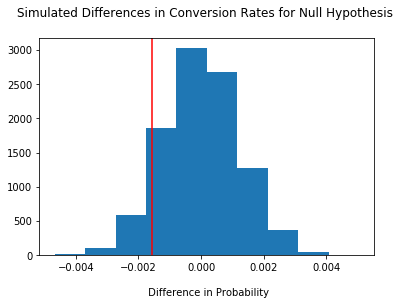

In [21]:
plt.hist(p_diffs)
plt.title("Simulated Differences in Conversion Rates for Null Hypothesis \n")
plt.xlabel("\n Difference in Probability")
plt.axvline(p_treatment - p_control, color='r');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [22]:
(p_diffs > (p_treatment - p_control)).mean()

0.904

**Observation**: The result of question j. is the p-value. In this case the computed p-value is 0.902

This result is far greater than the typical α level of 0.05 in business studies, or in other terms that our p-value is far greater than the 5% chance of committing a Type I error if the null is true.

As such, we would fail to reject the null hypothesis and conclude that there is not sufficient evidence to say that the conversion rate with the new page is higher than the conversion rate with the old page

l. We could also use a built-in z-test to achieve similar results. 

In [2]:
import statsmodels.api as sm

In [55]:
convert_old = df2.query('group == "control" and converted == 1').user_id.count()
convert_new = df2.query('group == "treatment" and converted == 1').user_id.count()
n_old = df2.query('group == "control"').user_id.count()
n_new = df2.query('group == "treatment"').user_id.count()

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.

In [63]:
sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')

(-1.3109241984234394, 0.9050583127590245)

**Observation**: The p-value obtained using a z-test (0.905) is similar and aligned with the pvalue obtained using a bootstrap methodology, leading to a similar conclusion.

<a id='regression'></a>
### Part III - A regression approach

`1.` Compare the previous A/B test by performing regression.

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic regression**

b. Create dummy variables for the page assignment and add an intercept

In [11]:
df2[['ab_page', 'old_page']] = pd.get_dummies(df2['landing_page'])
df2['intercept'] = 1
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,old_page,intercept
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,0,1
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,0,1
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,0,1


c. & d. Instantiate the model, and fit the model using the two dummy new/old page columns to predict whether or not an individual converts.

In [20]:
logit_model = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
result = logit_model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290583
Method:                           MLE   Df Model:                            1
Date:                Thu, 18 Oct 2018   Pseudo R-squ.:               8.085e-06
Time:                        13:55:10   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1897
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.312      0.190      -0.037       0.007
==============================================================================
"""

e. & f. **Observation**: The p-value (0,190) result from the logistic model output suggest that the new page (ab_page) is not statistically significant in predicting the conversion rate

The p-value (0.190) here remains above an $\alpha$ level of 0.05
The value is different because of the nature of the test, we are doing here a two tailed test. 
The initial conclusion still holds, we fail to reject the null in this situation.

By adding other factors (or predictors) in a linear regression, we are able to estimate the impact of each predictors on the continuous response variable, keeping the other predictors fixed.

The choice of the predictors imply to have a low correlation between each predictor and ensure their "independance"

g. Join the ab_page dataset with the country of residence of the users from the control and treatment groups an study the impact on the convertion rate

In [12]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,ab_page,old_page,intercept
user_id,,,,,,,,
630000,US,2017-01-19 06:26:06.548941,treatment,new_page,0,1,0,1
630001,US,2017-01-16 03:16:42.560309,treatment,new_page,1,1,0,1
630002,US,2017-01-19 19:20:56.438330,control,old_page,0,0,1,1
630003,US,2017-01-12 10:09:31.510471,treatment,new_page,0,1,0,1
630004,US,2017-01-18 20:23:58.824994,treatment,new_page,0,1,0,1


Create dummy variables for the countries of residence

In [67]:
df_new.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [13]:
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])
df_new.head()

,country,timestamp,group,landing_page,converted,ab_page,old_page,intercept,CA,UK,US
user_id,,,,,,,,,,,
630000,US,2017-01-19 06:26:06.548941,treatment,new_page,0,1,0,1,0,0,1
630001,US,2017-01-16 03:16:42.560309,treatment,new_page,1,1,0,1,0,0,1
630002,US,2017-01-19 19:20:56.438330,control,old_page,0,0,1,1,0,0,1
630003,US,2017-01-12 10:09:31.510471,treatment,new_page,0,1,0,1,0,0,1
630004,US,2017-01-18 20:23:58.824994,treatment,new_page,0,1,0,1,0,0,1


Instantiate the model, and fit the model using two dummy countries columns of the three to predict whether or not an individual converts.

In [69]:
logit_model = sm.Logit(df_new['converted'], df_new[['intercept', 'CA', 'UK']])
result = logit_model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Wed, 17 Oct 2018   Pseudo R-squ.:               1.521e-05
Time:                        17:18:23   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
CA            -0.0408      0.027     -1.518      0.129      -0.093       0.012
UK             0.0099      0.013      0.746      0.456      -0.016       0.036
==============================================================================
"""

**Observation**: The country predictors p-value remain above an $\alpha$ level of 0.05. We fail to reject the null hypothesis and conclude their is no sufficient evidence that the country or residence lead to a higher convertion rate

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion. 

Add interactions to the dataframe

In [14]:
df_new['CA_ab_page'] = df_new['ab_page'] * df_new['CA']
df_new['UK_ab_page'] = df_new['ab_page'] * df_new['UK']
df_new.head()

,country,timestamp,group,landing_page,converted,ab_page,old_page,intercept,CA,UK,US,CA_ab_page,UK_ab_page
user_id,,,,,,,,,,,,,
630000,US,2017-01-19 06:26:06.548941,treatment,new_page,0,1,0,1,0,0,1,0,0
630001,US,2017-01-16 03:16:42.560309,treatment,new_page,1,1,0,1,0,0,1,0,0
630002,US,2017-01-19 19:20:56.438330,control,old_page,0,0,1,1,0,0,1,0,0
630003,US,2017-01-12 10:09:31.510471,treatment,new_page,0,1,0,1,0,0,1,0,0
630004,US,2017-01-18 20:23:58.824994,treatment,new_page,0,1,0,1,0,0,1,0,0


Instantiate the model, and fit the model using dummy countries columns, the dummy column for the new page and their interaction to predict whether or not an individual converts.

In [16]:
logit_model = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page','CA', 'UK', 'CA_ab_page', 'UK_ab_page']])
result = logit_model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366108
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290579
Method:                           MLE   Df Model:                            5
Date:                Thu, 18 Oct 2018   Pseudo R-squ.:               3.483e-05
Time:                        10:24:30   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1918
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.506      0.132      -0.047       0.006
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
CA_ab_page    -0.0469      0.054     -0.872      0.383      -0.152       0.059
UK_ab_page     0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""

**Observation**: The various predictors and their interactions have p-value remain above an $\alpha$ level of 0.05. We fail to reject the null hypothesis and conclude their is no sufficient evidence that the interaction between country and a new page lead to a higher convertion rate

<a id='conclusion'></a>
## Conclusion

Based on the various test and analysis performed on the conversion rate change with a new page from this e-commerce website, we do not have sufficient evidence to suggest the new page lead to more conversion compared to the old page